In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import json
from google.colab import drive
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset labels
labels_csv_path = '/content/gdrive/MyDrive/labnotebook/9517/labels_mono.csv'
labels = pd.read_csv(labels_csv_path, header=None, names=["image", "prob_defect", "Module_Type"], sep="\\s+")

# Extract the image names from the labels DataFrame
image_names = labels['image'].tolist()

# Define paths
images_path = '/content/gdrive/MyDrive/labnotebook/9517/images/*.png'

# Initialize a list to store the images
imgs_resnet = []
labels_list = []

# Desired size for ResNet-50
desired_size = 224

for img_path in sorted(glob.glob(images_path)):
    img_name = "images/" + os.path.basename(img_path)  # Get the image file name
    if img_name in image_names:  # Check if the image name is in the labels list
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (desired_size, desired_size))
        imgs_resnet.append(img)

        # Append the corresponding label to the labels list
        label_index = image_names.index(img_name)  # Find the index of the image in labels
        labels_list.append(labels['prob_defect'].iloc[label_index])


# Convert images into a numpy array and preprocess for ResNet-50
X = np.array(imgs_resnet, dtype='float32')
X = tf.keras.applications.resnet50.preprocess_input(X)

# Normalize the data
X = X / 255.0

# Reshape X to add channel dimension (3 for RGB)
X = X.reshape((-1, desired_size, desired_size, 3))

# Split the dataset
x_train, x_val, y_train, y_val = train_test_split(X, np.array(labels_list), test_size=0.25, stratify=labels_list)

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ResNet-50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(desired_size, desired_size, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming you have 4 classes

# This is the model we will train
model_resnet = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model_resnet.fit(datagen.flow(x_train, y_train, batch_size=32),
                           epochs=60, validation_data=(x_val, y_val))

# Save the model and training history
model_save_path = '/content/gdrive/MyDrive/labnotebook/9517/my_resnet_model.h5'
history_save_path = '/content/gdrive/MyDrive/labnotebook/9517/resnet_history.json'
model_resnet.save(model_save_path)
with open(history_save_path, 'w') as file:
    json.dump(history.history, file)

# Print dataset information
print(f'Number of samples in x_train: {len(x_train)}')
print(f'Number of samples in y_train: {len(y_train)}')
print(f'Number of samples in x_val: {len(x_val)}')
print(f'Number of samples in y_val: {len(y_val)}')
print(f"Unique classes in y_train: {np.unique(y_train)}")
print(f"Unique classes in y_val: {np.unique(y_val)}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/60
26/26 [==============================] - 56s 504ms/step - loss: 0.6542 - accuracy: 0.6385 - val_loss: 120.4146 - val_accuracy: 0.5465
Epoch 2/60
26/26 [==============================] - 13s 474ms/step - loss: 0.4858 - accuracy: 0.6571 - val_loss: 15.6783 - val_accuracy: 0.5465
Epoch 3/60
26/26 [==============================] - 18s 675ms/step - loss: 0.4551 - accuracy: 0.6733 - val_loss: 6.6025 - val_accuracy: 0.5465
Epoch 4/60
26/26 [==============================] - 13s 515ms/step - loss: 0.6140 - accuracy: 0.6373 - val_loss: 0.6151 - val_accuracy: 0.5465
Epoch 5/60
26/26 [==============================] - 11s 412ms/step - loss: 0.4013 - accuracy: 0.6957 - val_loss: 1.0244 - val_accuracy: 0.5465
Epoch 6/60
26/26 [==============================] - 13s 505ms/step - loss: 0.3877 - ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Number of samples in x_train: 805
Number of samples in y_train: 805
Number of samples in x_val: 269
Number of samples in y_val: 269
Unique classes in y_train: [0.         0.33333333 0.66666667 1.        ]
Unique classes in y_val: [0.         0.33333333 0.66666667 1.        ]


9/9 [==============================] - 3s 44ms/step
Confusion Matrix
[[188   2]
 [ 29  50]]


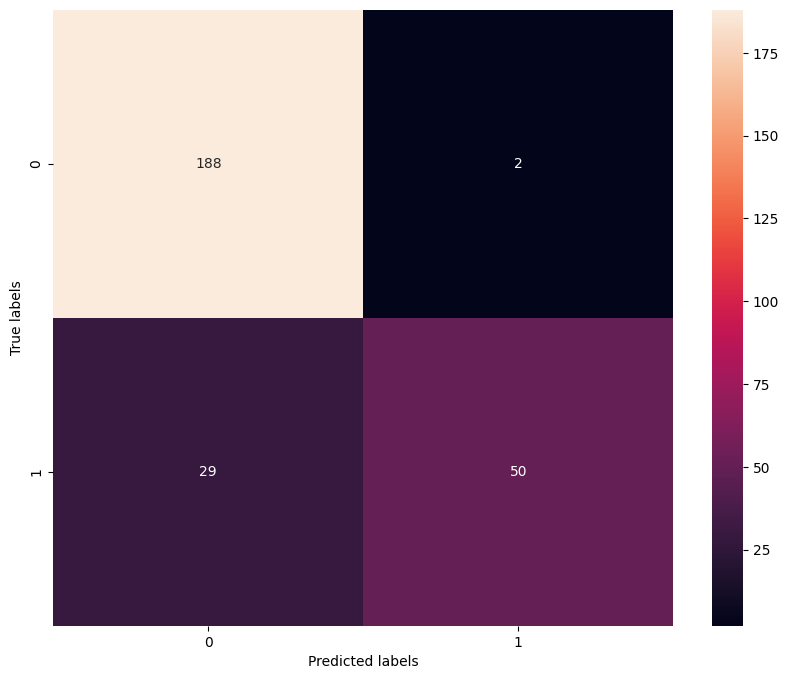

In [4]:
import tensorflow as tf
from tensorflow.math import confusion_matrix

# Evaluate the model
y_pred = model_resnet.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Convert confusion matrix from tensor to numpy array if you want to print or process it further
cm_array = cm.numpy()

# Print the confusion matrix
print('Confusion Matrix')
print(cm_array)

# You can also visualize the confusion matrix using seaborn for better readability
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm_array, annot=True, fmt='g')  # 'g' means generic format which could be either integer or float
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [5]:
import numpy as np

# Assuming y_pred_classes and y_val are already defined and contain the predicted and true labels respectively

# Get the number of classes from the data
num_classes = len(np.unique(np.concatenate((y_val, y_pred_classes))))

# Initialize arrays to hold the precision, recall, and F1-score
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

# Compute precision, recall, and F1-score for each class
for i in range(num_classes):
    true_positive = np.sum((y_val == i) & (y_pred_classes == i))
    false_positive = np.sum((y_val != i) & (y_pred_classes == i))
    false_negative = np.sum((y_val == i) & (y_pred_classes != i))

    # Calculate metrics for the current class
    precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print the classification report
print('Classification Report')
for i in range(num_classes):
    print(f'Class {i}:')
    print(f'    Precision: {precision[i]:.2f}')
    print(f'    Recall: {recall[i]:.2f}')
    print(f'    F1-Score: {f1_score[i]:.2f}')

# Overall accuracy
accuracy = np.sum(y_val == y_pred_classes) / len(y_val)
print(f'Accuracy: {accuracy:.2f}')


Classification Report
Class 0:
    Precision: 0.67
    Recall: 0.99
    F1-Score: 0.80
Class 1:
    Precision: 0.96
    Recall: 0.63
    F1-Score: 0.76
Class 2:
    Precision: 0.00
    Recall: 0.00
    F1-Score: 0.00
Class 3:
    Precision: 0.00
    Recall: 0.00
    F1-Score: 0.00
Accuracy: 0.72


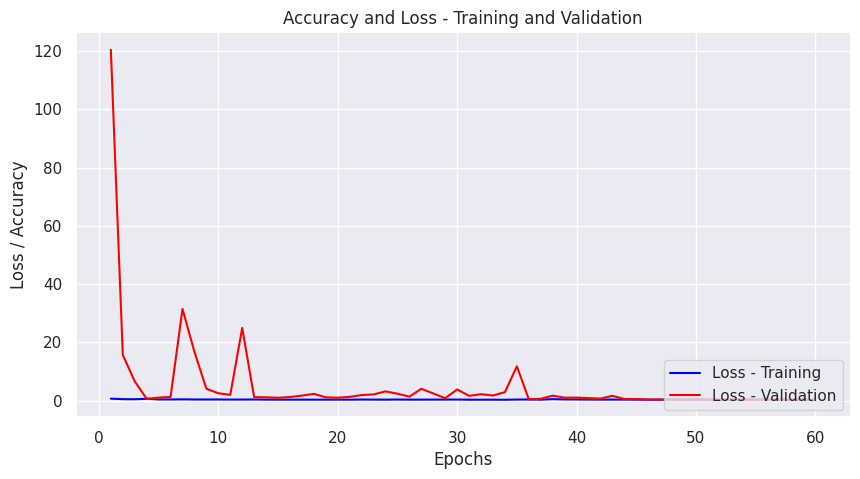

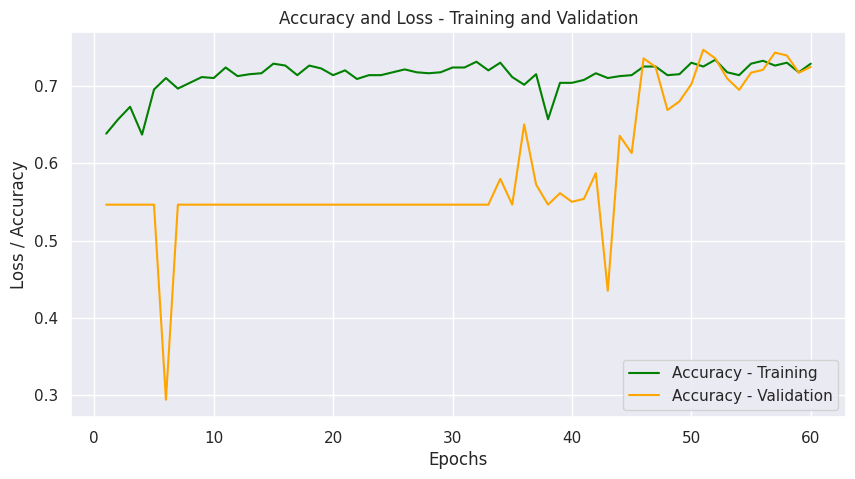

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the loss and accuracy values from the history.
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define the number of epochs.
epochs = range(1, len(loss) + 1)

# Plot the graphs.
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epochs, loss, label='Loss - Training', color='blue')
ax.plot(epochs, val_loss, label='Loss - Validation', color='red')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Accuracy and Loss - Training and Validation')
ax.legend(loc='lower right')

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epochs, acc, label='Accuracy - Training', color='green')
ax.plot(epochs, val_acc, label='Accuracy - Validation', color='orange')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Accuracy and Loss - Training and Validation')
ax.legend(loc='lower right')

plt.show()

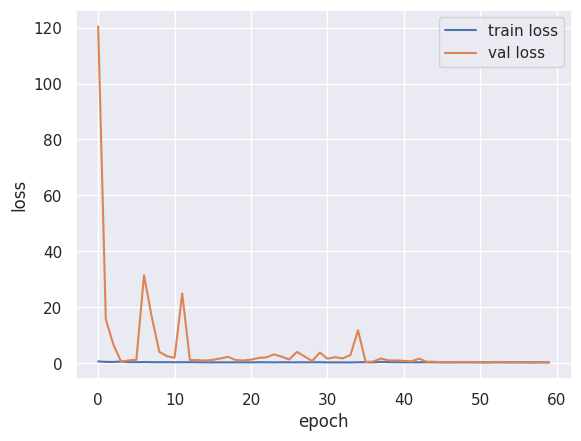

In [7]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss graph as a function of training.
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()